# Distributions of nodes and edges in MoA-net

In [1]:
import os
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

tqdm.pandas()

# Load networks

In [2]:
KG_DIR = '../data/kg'
FIG_DIR = '../figures'
os.makedirs(FIG_DIR, exist_ok=True)

In [3]:
kg = pd.read_csv(f'{KG_DIR}/final_kg.tsv', sep='\t')
kg.drop_duplicates(inplace=True)
kg.head(2)

,source,source_node_type,target,target_node_type,edge_type
0,pubchem.compound:10607,Compound,ncbigene:3553,Gene,upregulates
1,pubchem.compound:10607,Compound,ncbigene:203068,Gene,downregulates


# Get basic stats

In [4]:
kg.edge_type.value_counts()

interacts        86786
participates      4289
downregulates     2225
induces           1682
upregulates       1639
Name: edge_type, dtype: int64

# Get node counts

In [5]:
drugs = set()
proteins = set()
bps = set()

for source, target in tqdm(kg[['source', 'target']].values):
    if source.startswith('pubchem.compound:'):
        drugs.add(source)
    elif source.startswith('ncbigene:'):
        proteins.add(source)
    else:
        raise ValueError(f'Unknown source: {source}')

    if target.startswith('pubchem.compound:'):
        drugs.add(target)
    elif target.startswith('ncbigene:'):
        proteins.add(target)
    elif target.startswith('GO:'):
        bps.add(target)
    else:
        raise ValueError(f'Unknown target: {target}')

  0%|          | 0/96621 [00:00<?, ?it/s]

100%|██████████| 96621/96621 [00:00<00:00, 226599.65it/s]


### Get edges counts

In [6]:
drug_protein = 0
protein_protein = 0
protein_bps = 0
drug_bps = 0

for source, target in tqdm(kg[['source', 'target']].values):
    if 'pubchem.compound' in source and 'ncbigene' in target:
        drug_protein += 1
    elif 'ncbigene' in source and 'ncbigene' in target:
        protein_protein += 1
    elif 'ncbigene' in source and 'GO' in target:
        protein_bps += 1
    elif 'pubchem.compound' in source and 'GO' in target:
        drug_bps += 1
    else:
        print(source, target)

100%|██████████| 96621/96621 [00:00<00:00, 395352.68it/s]


## Summary stats

In [7]:
print('##### Number of nodes in MoA-net #####')
print(f'{len(drugs)}: # of unique drugs')
print(f'{len(proteins)}: # of unique proteins')
print(f'{len(bps)}: # of unique biological processes')

print('\n##### Number of edges in MoA-net ######')       
print(f'{len(kg)}: total # of interactions')
print(f'{drug_protein}: # of drug-protein interactions')
print(f'{protein_protein}: # of protein-protein interactions')
print(f'{protein_bps}: # of protein-process interactions')
print(f'{drug_bps}: # of drug-process interactions')

##### Number of nodes in MoA-net #####
313: # of unique drugs
9301: # of unique proteins
76: # of unique biological processes

##### Number of edges in MoA-net ######
96621: total # of interactions
3855: # of drug-protein interactions
86795: # of protein-protein interactions
4289: # of protein-process interactions
1682: # of drug-process interactions


# Plot distributions of nodes

In [8]:
data_nodes = {
    'Count':[
        len(drugs),
        len(proteins), 
        len(bps), 
    ],
    'Node Types':['Drugs','Genes/Proteins','Biological processes']
}

node_df = pd.DataFrame(data=data_nodes)
node_df.head()

,Count,Node Types
0,313,Drugs
1,9301,Genes/Proteins
2,76,Biological processes


In [9]:
data_edges = {
    'Count':[
        drug_protein,
        protein_protein,
        protein_bps, 
        drug_bps
    ],
    'Edge Types':[
        'drug-protein',
        'protein-protein',
        'protein-process',
        'drug-process'
    ]
}

edges_df = pd.DataFrame(data=data_edges)
edges_df

,Count,Edge Types
0,3855,drug-protein
1,86795,protein-protein
2,4289,protein-process
3,1682,drug-process


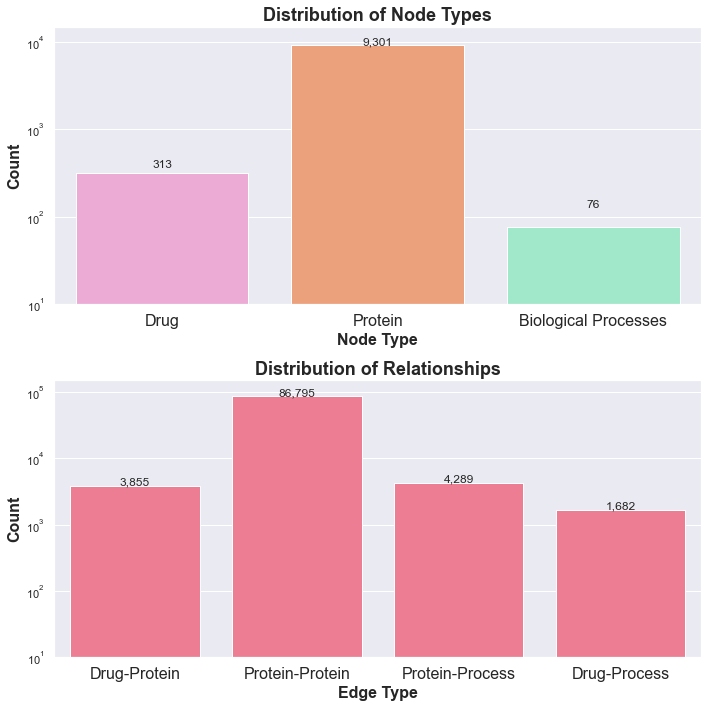

In [10]:
sns.set(rc={'figure.figsize':(10,10)})

# grid lines
sns.set_style("darkgrid")

plt.subplot(2, 1, 1)
bx1 = sns.barplot(
    x="Node Types", y="Count", data=node_df,
    palette=['#F6A0D8','#FE9A6B', '#95F3CC']
) 
plt.title(
    'Distribution of Node Types', 
    fontsize=18, 
    fontweight="bold"
)
plt.xlabel("Node Type", fontsize=16, fontweight="bold")
plt.ylabel("Count", fontsize=16, fontweight="bold")
plt.xticks(bx1.get_xticks(), labels=['Drug', 'Protein', 'Biological Processes'], fontsize=16)
plt.ylim(10, 15000)
plt.yscale("log") #the log transformation

for p in bx1.patches:
    _x = p.get_x() + p.get_width() / 2
    _y = p.get_y() + p.get_height() + 50
    value = int(p.get_height())
    bx1.text(_x, _y, f'{value:,}', ha="center") 

plt.subplot(2, 1, 2)
bx2 = sns.barplot(
    x="Edge Types", y="Count", data=edges_df, 
    color='#fe6b86'
)
plt.title(
    'Distribution of Relationships', 
    fontsize=18, 
    fontweight="bold"
)
plt.xlabel("Edge Type", fontsize=16, fontweight="bold")
plt.ylabel("Count", fontsize=16, fontweight="bold") 
plt.xticks(bx2.get_xticks(), labels=['Drug-Protein','Protein-Protein','Protein-Process', 'Drug-Process'], fontsize=16)
plt.ylim(10, 150000)

plt.yscale("log") #the log transformation

# Add counts above bars
for p in bx2.patches:
    _x = p.get_x() + p.get_width() / 2
    _y = p.get_y() + p.get_height() + 50
    value = int(p.get_height())
    bx2.text(_x, _y, f'{value:,}', ha="center")   


plt.tight_layout()
plt.savefig(
    f'{FIG_DIR}/graph-stats.png',
    dpi=400,
    bbox_inches='tight', 
)
plt.show()